# Clasificación Automática de Tickets con NLP

### Integrantes
* Sergio Godoy
* Rodrigo Mercado

## Descripción del Problema

Debe crear un modelo que pueda clasificar las quejas (complaints) de los clientes en función de los productos/servicios. Al hacerlo, puede segregar estos tickets en sus categorías relevantes y, por lo tanto, ayudar en la resolución rápida del problema.

Realizará el modelado de temas en los datos <b>.json</b> proporcionados por la empresa. Dado que estos datos no están etiquetados, debe aplicar NMF para analizar patrones y clasificar los tickets en los siguientes cinco grupos según sus productos/servicios:

* Tarjetas de Credito / Tarjetas Prepagadas (Credit card / Prepaid Card)

* Servicios de Cuentas de Banco (Bank account services)

* Reportes de Robos (Theft/Dispute reporting)

* Prestamos Hipotecarios y Otros Prestamos (Mortgages/loans)

* Otros

Con la ayuda del modelado de temas, podrá asignar cada ticket a su respectivo departamento/categoría. Luego puede usar estos datos para entrenar cualquier modelo supervisado, como regresión logística, árbol de decisión o bosque aleatorio. Usando este modelo entrenado, puede clasificar cualquier nuevo ticket de soporte de quejas de clientes en su departamento correspondiente.

## Flujo de trabajo a realizar:

Debe realizar las siguientes ocho tareas principales para completar la tarea:

1. Data Loading

2. Text preprocessing

3. Exploratory Data Analysis (EDA)

4. Feature Extraction

5. Topic modeling

6. Model building using Supervised Learning

7. Model training and evaluation

8. Model inference

## Setup e Importacion de Librerias

In [15]:
# ============================================================
#  NLP - CLASIFICACIÓN AUTOMÁTICA DE TICKETS (Colab)
#  Script completo con referencias a las secciones del notebook
#  Cumple la rúbrica: lectura → limpieza → lemas/POS → EDA
#  → TF-IDF/DTM → Topic Modelling (5) → Etiquetado
#  → Modelos supervisados → Evaluación → Inferencia
# ============================================================

# ------------------------------------------------------------
# [0] DEPENDENCIAS (Notebook: Setup/Installs)
# ------------------------------------------------------------

## SpaCy and en_core_web_sm installation
!pip install spacy
!pip install scikit-learn
!pip install wordcloud
!pip install unidecode

!python -m spacy download en_core_web_sm -q
!python -m spacy download es_core_news_sm -q

##run the following command in the console
#python -m spacy download en_core_web_sm

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.8/12.8 MB 40.9 MB/s eta 0:00:00
✔ Download and installation successful
You can now load the package via spacy.load('en_core_web_sm')
⚠ Restart to reload dependencies
If you are in a Jupyter or Colab notebook, you may need to restart Python in
order to load all the package's dependencies. You can do this by selecting the
'Restart kernel' or 'Restart runtime' option.
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.9/12.9 MB 136.2 MB/s eta 0:00:00
✔ Download and installation successful
You can now load the package via spacy.load('es_core_news_sm')
⚠ Restart to reload dependencies
If you are in a Jupyter or Colab notebook, you may need to restart Python in
order to load all the package's dependencies. You can do this by selecting the
'Restart kernel' or 'Restart runtime' option.


## Importing the necessary libraries

In [34]:
import warnings, os, re, json, gzip, string
warnings.filterwarnings("ignore")

import numpy as np
import pandas as pd
import requests

# Import NLTK libraries  (Notebook usa NLTK)
import nltk

packages = ["punkt", "punkt_tab", "wordnet", "stopwords", "omw-1.4"]
for pkg in packages:
    nltk.download(pkg, quiet=True)

print("✅ NLTK models descargados correctamente")


# Import Spacy libraries
import spacy
import en_core_web_sm
nlp = en_core_web_sm.load()

import matplotlib.pyplot as plt
from wordcloud import WordCloud
from unidecode import unidecode

from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer, TfidfTransformer
from sklearn.decomposition import NMF
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, f1_score, classification_report, confusion_matrix
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier

SEED = 42
np.random.seed(SEED)

✅ NLTK models descargados correctamente


## Loading the data **(Criterio Data Reading / Data Understanding)**

Los datos están en formato JSON y necesitamos convertirlos a un dataframe.

In [35]:
# ============================================================
# 1) Loading the data (Notebook §1.5)
#    Los datos están en JSON .gz -> convertir a DataFrame
# ============================================================
DATA_URL = "https://raw.githubusercontent.com/gaoigres/Proyecto2_NLP_Clasificacion_Automatica_de_Tickets/main/data/complaints.json.gz" # Corresponde a la dirección donde está localizado el archivo (se debe cambiar si está a nivel local)
                                                                                                                                       # Se usa un archivo comprimido .gz debido a que GitHub solo admite archivos de tamaño inferior a 25 MB

r = requests.get(DATA_URL, timeout=60)
r.raise_for_status()
text = gzip.decompress(r.content).decode("utf-8", errors="ignore")

def parse_json_or_jsonl(txt: str):
    lines = [l for l in txt.splitlines() if l.strip()]
    # JSONL
    if len(lines) > 1 and lines[0].strip().startswith("{"):
        return [json.loads(l) for l in lines]
    # JSON
    obj = json.loads(txt)
    if isinstance(obj, list):  return obj
    if isinstance(obj, dict):  return [obj]
    raise ValueError("Formato JSON no reconocido.")

data = parse_json_or_jsonl(text)
df = pd.json_normalize(data)  # como en el notebook
display(df.head()); print("Shape:", df.shape)



,_index,_type,_id,_score,_source.tags,_source.zip_code,_source.complaint_id,_source.issue,_source.date_received,_source.state,...,_source.company_response,_source.company,_source.submitted_via,_source.date_sent_to_company,_source.company_public_response,_source.sub_product,_source.timely,_source.complaint_what_happened,_source.sub_issue,_source.consumer_consent_provided
0,complaint-public-v2,complaint,3211475,0.0,None,90301,3211475,Attempts to collect debt not owed,2019-04-13T12:00:00-05:00,CA,...,Closed with explanation,JPMORGAN CHASE & CO.,Web,2019-04-13T12:00:00-05:00,None,Credit card debt,Yes,,Debt is not yours,Consent not provided
1,complaint-public-v2,complaint,3229299,0.0,Servicemember,319XX,3229299,Written notification about debt,2019-05-01T12:00:00-05:00,GA,...,Closed with explanation,JPMORGAN CHASE & CO.,Web,2019-05-01T12:00:00-05:00,None,Credit card debt,Yes,Good morning my name is XXXX XXXX and I apprec...,Didn't receive enough information to verify debt,Consent provided
2,complaint-public-v2,complaint,3199379,0.0,None,77069,3199379,"Other features, terms, or problems",2019-04-02T12:00:00-05:00,TX,...,Closed with explanation,JPMORGAN CHASE & CO.,Web,2019-04-02T12:00:00-05:00,None,General-purpose credit card or charge card,Yes,I upgraded my XXXX XXXX card in XX/XX/2018 and...,Problem with rewards from credit card,Consent provided
3,complaint-public-v2,complaint,2673060,0.0,None,48066,2673060,Trouble during payment process,2017-09-13T12:00:00-05:00,MI,...,Closed with explanation,JPMORGAN CHASE & CO.,Web,2017-09-14T12:00:00-05:00,None,Conventional home mortgage,Yes,,None,Consent not provided
4,complaint-public-v2,complaint,3203545,0.0,None,10473,3203545,Fees or interest,2019-04-05T12:00:00-05:00,NY,...,Closed with explanation,JPMORGAN CHASE & CO.,Referral,2019-04-05T12:00:00-05:00,None,General-purpose credit card or charge card,Yes,,Charged too much interest,N/A


Shape: (78313, 22)


## Data preparation **(Criterio Data Cleaning)**

In [36]:
# Inspect the dataframe to understand the given data.
print("Column names:", df.columns.tolist())



Column names: ['_index', '_type', '_id', '_score', '_source.tags', '_source.zip_code', '_source.complaint_id', '_source.issue', '_source.date_received', '_source.state', '_source.consumer_disputed', '_source.product', '_source.company_response', '_source.company', '_source.submitted_via', '_source.date_sent_to_company', '_source.company_public_response', '_source.sub_product', '_source.timely', '_source.complaint_what_happened', '_source.sub_issue', '_source.consumer_consent_provided']


In [37]:
# Assign new column names  -> estandarizar a 'Complaint'
candidate_cols = [
    "Complaint","complaint","complaint_what_happened","description","narrative",
    "text","issue","body","message","content","ticket"
]
if "Complaint" not in df.columns:
    for c in candidate_cols:
        if c in df.columns:
            df = df.rename(columns={c: "Complaint"})
            break
if "Complaint" not in df.columns:
    # si no existe, escoger la columna object más larga promedio
    lens = {c: df[c].astype(str).str.len().mean()
            for c in df.columns if df[c].dtype==object}
    best = max(lens, key=lens.get)
    df = df.rename(columns={best: "Complaint"})
print("✅ Text column standardized to 'Complaint'")


✅ Text column standardized to 'Complaint'


In [38]:
# Assign nan in place of blanks in the complaints column
df["Complaint"] = df["Complaint"].astype(str).str.strip()
df["Complaint"].replace("", np.nan, inplace=True)


In [39]:
# Remove all rows where complaints column is nan
df = df.dropna(subset=["Complaint"]).reset_index(drop=True)
print("Remaining records:", len(df))

Remaining records: 21072


## Prepare the text for topic modeling

Una vez que haya eliminado todas las quejas en blanco, debe:

* Make the text lowercase
* Remove text in square brackets
* Remove punctuation
* Remove words containing numbers

Una vez que haya realizado estas operaciones de limpieza, debe realizar lo siguiente:

* Lemmatize the texts
* Extract the POS tags of the lemmatized text and remove all the words which have tags other than NN[tag == "NN"].


**(Criterio Data Cleaning continuación)**

In [40]:
# Write your function here to clean the text and remove all the unnecessary elements.

STOP = set(stopwords.words("english"))
WN   = WordNetLemmatizer()

def clean_text(s: str) -> str:
    s = s.replace("\n"," ").replace("\r"," ")
    s = re.sub(r"\[.*?\]", " ", s)                # remove text in square brackets
    s = re.sub(r"http\S+|www\.\S+|\S+@\S+", " ", s)
    s = re.sub(r"#\w+|\@\w+", " ", s)
    s = re.sub(r"[0-9]+", " ", s)                 # remove words containing numbers
    s = unidecode(s.lower())
    s = s.translate(str.maketrans("", "", string.punctuation))
    s = re.sub(r"\s+", " ", s).strip()
    return s


**(Criterio Data Preprocessing)**

In [41]:
# Write your function to Lemmatize the texts

def lemmatize_text(s: str) -> str:
    toks = word_tokenize(s)
    toks = [t for t in toks if t not in STOP]
    toks = [WN.lemmatize(t) for t in toks]
    toks = [t for t in toks if len(t) > 2]
    return " ".join(toks)

In [42]:
# Create a dataframe('df_clean') that will have only the complaints and the lemmatized complaints

df_clean = df[["Complaint"]].copy()
df_clean["complaint_clean"] = df_clean["Complaint"].map(clean_text)
df_clean["lemmatized"]      = df_clean["complaint_clean"].map(lemmatize_text)
df_clean.head()


,Complaint,complaint_clean,lemmatized
0,Good morning my name is XXXX XXXX and I apprec...,good morning my name is xxxx xxxx and i apprec...,good morning name xxxx xxxx appreciate could h...
1,I upgraded my XXXX XXXX card in XX/XX/2018 and...,i upgraded my xxxx xxxx card in xxxx and was t...,upgraded xxxx xxxx card xxxx told agent upgrad...
2,Chase Card was reported on XX/XX/2019. However...,chase card was reported on xxxx however fraudu...,chase card reported xxxx however fraudulent ap...
3,"On XX/XX/2018, while trying to book a XXXX XX...",on xxxx while trying to book a xxxx xxxx ticke...,xxxx trying book xxxx xxxx ticket came across ...
4,my grand son give me check for {$1600.00} i de...,my grand son give me check for i deposit it in...,grand son give check deposit chase account fun...


POS tagging y remover todo excepto NN (tag == "NN")

In [43]:
#Write your function to extract the POS tags

def pos_tag(text: str) -> str:
    doc = nlp(text)
    # mantener solo NOUN y PROPN, además de NN* del tag_ (consistente con indicación 'NN')
    keep = []
    for t in doc:
        if t.is_space or t.is_punct:
            continue
        if t.tag_.startswith("NN") or t.pos_ in ("NOUN","PROPN"):
            keep.append(t.lemma_.lower())
    keep = [k for k in keep if len(k) > 2 and k != "-pron-"]
    return " ".join(keep)

df_clean["complaint_POS_removed"] = df_clean["lemmatized"].map(pos_tag)

In [44]:
#The clean dataframe should now contain the raw complaint, lemmatized complaint and the complaint after removing POS tags.
df_clean.head()

,Complaint,complaint_clean,lemmatized,complaint_POS_removed
0,Good morning my name is XXXX XXXX and I apprec...,good morning my name is xxxx xxxx and i apprec...,good morning name xxxx xxxx appreciate could h...,morning name xxxx xxxx chase bank cardmember s...
1,I upgraded my XXXX XXXX card in XX/XX/2018 and...,i upgraded my xxxx xxxx card in xxxx and was t...,upgraded xxxx xxxx card xxxx told agent upgrad...,xxxx xxxx card xxxx agent upgrade anniversary ...
2,Chase Card was reported on XX/XX/2019. However...,chase card was reported on xxxx however fraudu...,chase card reported xxxx however fraudulent ap...,chase card xxxx application identity consent s...
3,"On XX/XX/2018, while trying to book a XXXX XX...",on xxxx while trying to book a xxxx xxxx ticke...,xxxx trying book xxxx xxxx ticket came across ...,xxxx book xxxx xxxx ticket offer ticket reward...
4,my grand son give me check for {$1600.00} i de...,my grand son give me check for i deposit it in...,grand son give check deposit chase account fun...,son check deposit chase account fund clear cha...


## Exploratory data analysis to get familiar with the data. **(Criterio Data Visualization)**

Escriba el código en esta tarea para realizar lo siguiente:

* Visualiza los datos según la longitud del carácteres 'Complaint'
* Usando una nube de palabras, encuentre las top 40 palabras más frecuentes de todos los artículos después de procesar el texto
* Encuentre los mejores unigramas, bigramas y trigramas por frecuencia entre todas las quejas después de procesar el texto. '

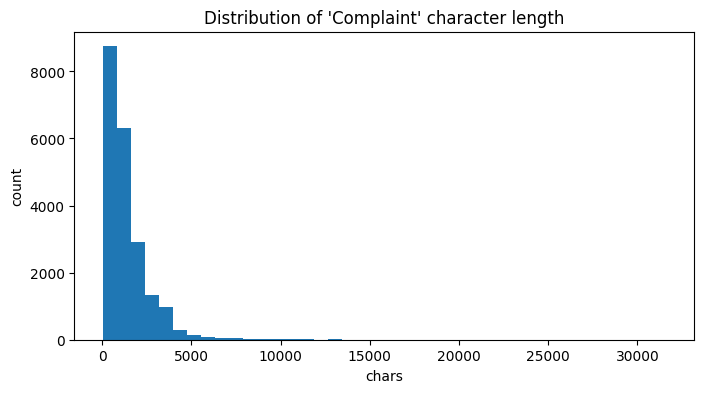

In [49]:
# Write your code here to visualise the data according to the 'Complaint' character length

df_clean["len_chars"] = df_clean["Complaint"].str.len()
plt.figure(figsize=(8,4))
plt.hist(df_clean["len_chars"], bins=40)
plt.title("Distribution of 'Complaint' character length")
plt.xlabel("chars"); plt.ylabel("count"); plt.show()


#### Find the top 40 words by frequency among all the articles after processing the text.

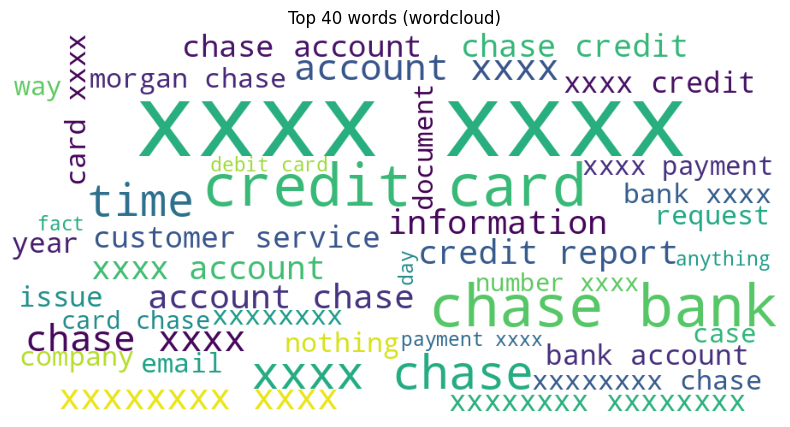

In [50]:
#Using a word cloud find the top 40 words by frequency among all the articles after processing the text

wc = WordCloud(width=900, height=450, background_color="white", max_words=40)
wc = wc.generate(" ".join(df_clean["complaint_POS_removed"].tolist()))
plt.figure(figsize=(10,5)); plt.imshow(wc); plt.axis("off"); plt.title("Top 40 words (wordcloud)"); plt.show()


In [51]:
#Removing -PRON- from the text corpus
df_clean['Complaint_clean'] = df_clean['complaint_POS_removed'].str.replace('-PRON-','', regex=False)


#### Find the top unigrams,bigrams and trigrams by frequency among all the complaints after processing the text.

In [64]:
#Write your code here to find the top 30 unigram frequency among the complaints in the cleaned datafram(df_clean).

def top_ngrams(texts, ngram=(1,1), topk=30):
    vec = CountVectorizer(ngram_range=ngram, min_df=2, max_df=0.95)
    X = vec.fit_transform(texts)
    freqs = np.asarray(X.sum(axis=0)).ravel()
    vocab = np.array([t for t,_ in sorted(vec.vocabulary_.items(), key=lambda x: x[1])])
    idxs = freqs.argsort()[::-1][:topk]
    return list(zip(vocab[idxs], freqs[idxs]))

uni = top_ngrams(df_clean["Complaint_clean"], (1,1), 30)
bi  = top_ngrams(df_clean["Complaint_clean"], (2,2), 30)
tri = top_ngrams(df_clean["Complaint_clean"], (3,3), 30)

print("Top 10 unigrams:", uni[:10])
print("Top 10 bigrams:", bi[:10])
print("Top 10 trigrams:", tri[:10])

Top 10 unigrams: [(np.str_('xxxx'), np.int64(200525)), (np.str_('chase'), np.int64(78137)), (np.str_('account'), np.int64(47478)), (np.str_('credit'), np.int64(33031)), (np.str_('card'), np.int64(30427)), (np.str_('xxxxxxxx'), np.int64(29198)), (np.str_('bank'), np.int64(28177)), (np.str_('payment'), np.int64(21172)), (np.str_('time'), np.int64(16016)), (np.str_('day'), np.int64(13224))]
Top 10 bigrams: [(np.str_('xxxx xxxx'), np.int64(92189)), (np.str_('chase bank'), np.int64(12898)), (np.str_('credit card'), np.int64(12850)), (np.str_('xxxx chase'), np.int64(7475)), (np.str_('chase xxxx'), np.int64(4552)), (np.str_('account xxxx'), np.int64(4516)), (np.str_('xxxxxxxx xxxx'), np.int64(4406)), (np.str_('credit report'), np.int64(3869)), (np.str_('account chase'), np.int64(3860)), (np.str_('xxxx xxxxxxxx'), np.int64(3651))]
Top 10 trigrams: [(np.str_('xxxx xxxx xxxx'), np.int64(46962)), (np.str_('xxxx xxxx chase'), np.int64(3127)), (np.str_('chase credit card'), np.int64(2343)), (np.str

## The personal details of customer has been masked in the dataset with xxxx. Let's remove the masked text as this will be of no use for our analysis

In [65]:
# ============================================================
# 1.9 Remove masked personal details 'xxxx' (Notebook)
# ============================================================
df_clean['Complaint_clean'] = df_clean['Complaint_clean'].str.replace('xxxx','', regex=False)
df_clean.head()

,Complaint,complaint_clean,lemmatized,complaint_POS_removed,Complaint_clean,len_chars
0,Good morning my name is XXXX XXXX and I apprec...,good morning my name is xxxx xxxx and i apprec...,good morning name xxxx xxxx appreciate could h...,morning name xxxx xxxx chase bank cardmember s...,morning name chase bank cardmember service c...,486
1,I upgraded my XXXX XXXX card in XX/XX/2018 and...,i upgraded my xxxx xxxx card in xxxx and was t...,upgraded xxxx xxxx card xxxx told agent upgrad...,xxxx xxxx card xxxx agent upgrade anniversary ...,card agent upgrade anniversary date agent i...,355
2,Chase Card was reported on XX/XX/2019. However...,chase card was reported on xxxx however fraudu...,chase card reported xxxx however fraudulent ap...,chase card xxxx application identity consent s...,chase card application identity consent servi...,224
3,"On XX/XX/2018, while trying to book a XXXX XX...",on xxxx while trying to book a xxxx xxxx ticke...,xxxx trying book xxxx xxxx ticket came across ...,xxxx book xxxx xxxx ticket offer ticket reward...,book ticket offer ticket reward card inform...,1502
4,my grand son give me check for {$1600.00} i de...,my grand son give me check for i deposit it in...,grand son give check deposit chase account fun...,son check deposit chase account fund clear cha...,son check deposit chase account fund clear cha...,477


## Feature Extraction **(Criterio Feature Extraction)**
Convierta los textos sin procesar en una matriz de características TF-IDF

**max_df** is used for removing terms that appear too frequently, also known as "corpus-specific stop words"
max_df = 0.95 means "ignore terms that appear in more than 95% of the complaints"

**min_df** is used for removing terms that appear too infrequently
min_df = 2 means "ignore terms that appear in less than 2 complaints"

In [66]:
# Write your code here to initialise the TfidfVectorizer

tfidf = TfidfVectorizer(max_df=0.95, min_df=2, ngram_range=(1,2))
dtm   = tfidf.fit_transform(df_clean["Complaint_clean"])
print("DTM shape:", dtm.shape)

DTM shape: (21072, 108890)


#### Create a document term matrix using fit_transform

The contents of a document term matrix are tuples of (complaint_id,token_id) tf-idf score:
The tuples that are not there have a tf-idf score of 0

In [67]:
# Write your code here to create the Document Term Matrix by transforming the complaints column present in df_clean.

dtm = tfidf.fit_transform(df_clean["Complaint_clean"])
dtm

<Compressed Sparse Row sparse matrix of dtype 'float64'
	with 1525162 stored elements and shape (21072, 108890)>

## Topic Modelling using NMF **(Criterio Topic Modelling)**

Non-Negative Matrix Factorization (NMF) es una técnica no supervisada, por lo que no hay etiquetas de temas en los que se entrenará el modelo. La forma en que funciona es que NMF descompone (o factoriza) vectores de alta dimensión en una representación de menor dimensión. Estos vectores de menor dimensión no son negativos, lo que también significa que sus coeficientes no son negativos.

En esta tarea tienes que realizar lo siguiente:

* Find the best number of clusters
* Apply the best number to create word clusters
* Inspect & validate the correction of each cluster wrt the complaints
* Correct the labels if needed
* Map the clusters to topics/cluster names

* Encuentra el mejor número de clústeres
* Aplicar el mejor número para crear grupos de palabras
* Inspeccionar y validar la corrección de cada grupo frente a las quejas (Complaints)
* Corrija las etiquetas si es necesario
* Mapear el grupo de nombres de topicos/clusters

In [68]:
from sklearn.decomposition import NMF

## Manual Topic Modeling
Debe adoptar el enfoque de prueba y error para encontrar la mejor cantidad de topicos para su modelo NMF.

El único parámetro que se requiere es el número de componentes, es decir, el número de topicos que queremos. Este es el paso más crucial en todo el proceso de modelado de topicos y afectará en gran medida la calidad de sus topicos finales.

In [69]:
# Load your nmf_model with the n_components i.e 5 (Establece el número de tópicos en 5)
num_topics = 5     # write the value you want to test out

# keep the random_state = 40
nmf_model = NMF(n_components=num_topics, random_state=40, init="nndsvd", max_iter=400)


In [70]:
nmf_model.fit(dtm)
len(tfidf.get_feature_names_out())

108890

In [71]:
# Print the Top15 words for each of the topics
terms = np.array(tfidf.get_feature_names_out())
for k, comp in enumerate(nmf_model.components_):
    top_idx = np.argsort(comp)[::-1][:15]
    print(f"\nTopic {k}: " + ", ".join(terms[top_idx]))


Topic 0: account, bank, chase, check, money, chase bank, fund, transaction, deposit, day, branch, account chase, claim, bank account, chase account

Topic 1: card, credit, credit card, chase, charge, chase credit, card chase, dispute, purchase, company, service, balance, chase card, time, card account

Topic 2: loan, mortgage, chase, modification, home, property, year, letter, foreclosure, time, document, rate, loan modification, sale, chase mortgage

Topic 3: inquiry, report, credit, credit report, inquiry credit, jpmcb, reporting, bureau, report credit, jpmcb card, credit bureau, card inquiry, credit reporting, report inquiry, account credit

Topic 4: payment, balance, payment payment, interest, fee, month, statement, payment chase, chase payment, amount, payment account, day, account, credit, account payment


In [72]:
#Create the best topic for each complaint in terms of integer value 0,1,2,3 & 4

W = nmf_model.transform(dtm)
best_topic = W.argmax(axis=1)


In [73]:
#Assign the best topic to each of the cmplaints in Topic Column

df_clean['Topic'] = best_topic
df_clean.head()

,Complaint,complaint_clean,lemmatized,complaint_POS_removed,Complaint_clean,len_chars,Topic
0,Good morning my name is XXXX XXXX and I apprec...,good morning my name is xxxx xxxx and i apprec...,good morning name xxxx xxxx appreciate could h...,morning name xxxx xxxx chase bank cardmember s...,morning name chase bank cardmember service c...,486,0
1,I upgraded my XXXX XXXX card in XX/XX/2018 and...,i upgraded my xxxx xxxx card in xxxx and was t...,upgraded xxxx xxxx card xxxx told agent upgrad...,xxxx xxxx card xxxx agent upgrade anniversary ...,card agent upgrade anniversary date agent i...,355,1
2,Chase Card was reported on XX/XX/2019. However...,chase card was reported on xxxx however fraudu...,chase card reported xxxx however fraudulent ap...,chase card xxxx application identity consent s...,chase card application identity consent servi...,224,1
3,"On XX/XX/2018, while trying to book a XXXX XX...",on xxxx while trying to book a xxxx xxxx ticke...,xxxx trying book xxxx xxxx ticket came across ...,xxxx book xxxx xxxx ticket offer ticket reward...,book ticket offer ticket reward card inform...,1502,3
4,my grand son give me check for {$1600.00} i de...,my grand son give me check for i deposit it in...,grand son give check deposit chase account fun...,son check deposit chase account fund clear cha...,son check deposit chase account fund clear cha...,477,0


In [74]:
#Print the first 5 Complaint for each of the Topics
display(df_clean.groupby('Topic').head(5).sort_values('Topic'))

,Complaint,complaint_clean,lemmatized,complaint_POS_removed,Complaint_clean,len_chars,Topic
0,Good morning my name is XXXX XXXX and I apprec...,good morning my name is xxxx xxxx and i apprec...,good morning name xxxx xxxx appreciate could h...,morning name xxxx xxxx chase bank cardmember s...,morning name chase bank cardmember service c...,486,0
4,my grand son give me check for {$1600.00} i de...,my grand son give me check for i deposit it in...,grand son give check deposit chase account fun...,son check deposit chase account fund clear cha...,son check deposit chase account fund clear cha...,477,0
6,With out notice J.P. Morgan Chase restricted m...,with out notice jp morgan chase restricted my ...,notice morgan chase restricted account debit c...,notice morgan chase account debit card tuesday...,notice morgan chase account debit card tuesday...,2277,0
8,"On XXXX XX/XX/2019, I made a {$300.00} payment...",on xxxx xxxx i made a payment to an online ret...,xxxx xxxx made payment online retailer using c...,xxxx xxxx payment retailer chase pay xxxx chas...,payment retailer chase pay chase website sc...,3541,0
10,mishandling of this account by Chase auto and ...,mishandling of this account by chase auto and ...,mishandling account chase auto xxxx,account chase auto xxxx,account chase auto,51,0
16,"XXXX XXXX a sofa, love seat, table and chairs ...",xxxx xxxx a sofa love seat table and chairs an...,xxxx xxxx sofa love seat table chair never del...,xxxx xxxx sofa love seat table chair debit car...,sofa love seat table chair debit card bank v...,165,1
2,Chase Card was reported on XX/XX/2019. However...,chase card was reported on xxxx however fraudu...,chase card reported xxxx however fraudulent ap...,chase card xxxx application identity consent s...,chase card application identity consent servi...,224,1
1,I upgraded my XXXX XXXX card in XX/XX/2018 and...,i upgraded my xxxx xxxx card in xxxx and was t...,upgraded xxxx xxxx card xxxx told agent upgrad...,xxxx xxxx card xxxx agent upgrade anniversary ...,card agent upgrade anniversary date agent i...,355,1
21,I AM A SENIOR CITIZEN THAT HAS BEEN SCAMMED BY...,i am a senior citizen that has been scammed by...,senior citizen scammed several company xxxx xx...,citizen company xxxx xxxx time share company n...,citizen company time share company nothing r...,350,1
14,My chase amazon card was declined for a cateri...,my chase amazon card was declined for a cateri...,chase amazon card declined catering order plac...,chase amazon card catering order brother funer...,chase amazon card catering order brother funer...,1972,1


#### After evaluating the mapping, if the topics assigned are correct then assign these names to the relevant topic:
* Bank Account services
* Credit card or prepaid card
* Theft/Dispute Reporting
* Mortgage/Loan
* Others

In [83]:
#Create the dictionary of Topic names and Topics

Topic_names = {
    0: "Bank Account services",
    1: "Credit card / prepaid card",
    2: "Mortgage / Loan",
    3: "Theft / Dispute Reporting",
    4: "Others"
}
if Topic_names:
    df_clean['Topic'] = df_clean['Topic'].map(Topic_names)
df_clean.head()

,Complaint,complaint_clean,lemmatized,complaint_POS_removed,Complaint_clean,len_chars,Topic
0,Good morning my name is XXXX XXXX and I apprec...,good morning my name is xxxx xxxx and i apprec...,good morning name xxxx xxxx appreciate could h...,morning name xxxx xxxx chase bank cardmember s...,morning name chase bank cardmember service c...,486,Bank Account services
1,I upgraded my XXXX XXXX card in XX/XX/2018 and...,i upgraded my xxxx xxxx card in xxxx and was t...,upgraded xxxx xxxx card xxxx told agent upgrad...,xxxx xxxx card xxxx agent upgrade anniversary ...,card agent upgrade anniversary date agent i...,355,Credit card / prepaid card
2,Chase Card was reported on XX/XX/2019. However...,chase card was reported on xxxx however fraudu...,chase card reported xxxx however fraudulent ap...,chase card xxxx application identity consent s...,chase card application identity consent servi...,224,Credit card / prepaid card
3,"On XX/XX/2018, while trying to book a XXXX XX...",on xxxx while trying to book a xxxx xxxx ticke...,xxxx trying book xxxx xxxx ticket came across ...,xxxx book xxxx xxxx ticket offer ticket reward...,book ticket offer ticket reward card inform...,1502,Theft / Dispute Reporting
4,my grand son give me check for {$1600.00} i de...,my grand son give me check for i deposit it in...,grand son give check deposit chase account fun...,son check deposit chase account fund clear cha...,son check deposit chase account fund clear cha...,477,Bank Account services


## Supervised model to predict any new complaints to the relevant Topics.

Hasta ahora ha creado el modelo para crear los temas para cada queja. Entonces, en la siguiente sección, los utilizará para clasificar cualquier queja nueva.

Dado que utilizará la técnica de aprendizaje supervisado, tenemos que convertir los nombres de los temas en números (las matrices numpy solo entienden los números)

In [84]:

training_data = df_clean[["Complaint_clean","Topic"]].dropna().reset_index(drop=True)
training_data.head()

,Complaint_clean,Topic
0,morning name chase bank cardmember service c...,Bank Account services
1,card agent upgrade anniversary date agent i...,Credit card / prepaid card
2,chase card application identity consent servi...,Credit card / prepaid card
3,book ticket offer ticket reward card inform...,Theft / Dispute Reporting
4,son check deposit chase account fund clear cha...,Bank Account services


#### Apply the supervised models on the training data created. In this process, you have to do the following:
* Create the vector counts using Count Vectoriser
* Transform the word vecotr to tf-idf
* Create the train & test data using the train_test_split on the tf-idf & topics


In [85]:

#Write your code to get the Vector count

count_vec = CountVectorizer(min_df=2, max_df=0.95, ngram_range=(1,2))
X_counts  = count_vec.fit_transform(training_data["Complaint_clean"])

#Write your code here to transform the word vector to tf-idf

tfidf_tr = TfidfTransformer()
X_tfidf  = tfidf_tr.fit_transform(X_counts)

**(Criterio Model Building)**



You have to try atleast 3 models on the train & test data from these options:
* Logistic regression
* Decision Tree
* Random Forest
* Naive Bayes (optional)

Using the required evaluation metrics judge the tried models and select the ones performing the best


== LogisticRegression ==
Accuracy: 0.9613 F1_weighted: 0.9614
                            precision    recall  f1-score   support

     Bank Account services       0.98      0.96      0.97      1310
Credit card / prepaid card       0.97      0.95      0.96      1193
           Mortgage / Loan       0.95      0.97      0.96       801
                    Others       0.96      0.95      0.95       522
 Theft / Dispute Reporting       0.91      0.98      0.95       389

                  accuracy                           0.96      4215
                 macro avg       0.95      0.96      0.96      4215
              weighted avg       0.96      0.96      0.96      4215



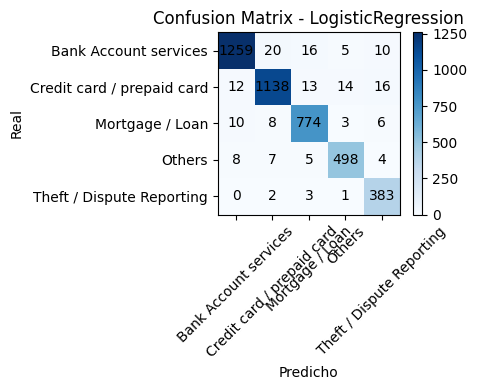


== DecisionTree ==
Accuracy: 0.8484 F1_weighted: 0.8484
                            precision    recall  f1-score   support

     Bank Account services       0.86      0.87      0.86      1310
Credit card / prepaid card       0.86      0.86      0.86      1193
           Mortgage / Loan       0.86      0.83      0.84       801
                    Others       0.80      0.82      0.81       522
 Theft / Dispute Reporting       0.81      0.81      0.81       389

                  accuracy                           0.85      4215
                 macro avg       0.84      0.84      0.84      4215
              weighted avg       0.85      0.85      0.85      4215



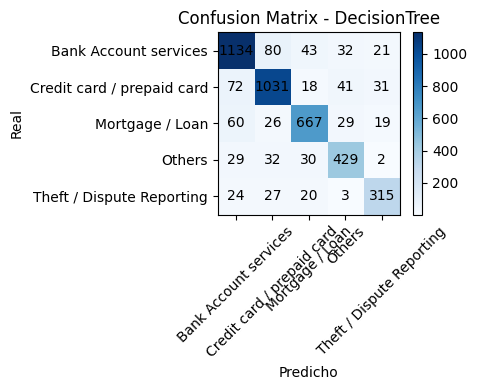


== RandomForest ==
Accuracy: 0.8918 F1_weighted: 0.8885
                            precision    recall  f1-score   support

     Bank Account services       0.88      0.95      0.92      1310
Credit card / prepaid card       0.86      0.95      0.90      1193
           Mortgage / Loan       0.92      0.89      0.90       801
                    Others       0.98      0.63      0.77       522
 Theft / Dispute Reporting       0.92      0.85      0.88       389

                  accuracy                           0.89      4215
                 macro avg       0.91      0.86      0.87      4215
              weighted avg       0.90      0.89      0.89      4215



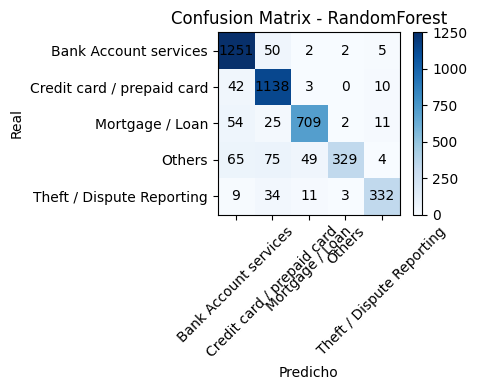

In [86]:
# Write your code here to build any 3 models and evaluate them using the required metrics

# Split
X_train, X_test, y_train, y_test = train_test_split(
    X_tfidf, training_data["Topic"], test_size=0.2, random_state=SEED, stratify=training_data["Topic"]
)

models = {
    "LogisticRegression": LogisticRegression(max_iter=300, class_weight="balanced", random_state=SEED),
    "DecisionTree": DecisionTreeClassifier(random_state=SEED),
    "RandomForest": RandomForestClassifier(n_estimators=300, random_state=SEED)
}

scores = {}
for name, clf in models.items():
    clf.fit(X_train, y_train)
    pred = clf.predict(X_test)
    acc = accuracy_score(y_test, pred)
    f1  = f1_score(y_test, pred, average="weighted")
    scores[name] = (acc, f1, pred)
    print(f"\n== {name} ==")
    print("Accuracy:", round(acc,4), "F1_weighted:", round(f1,4))
    print(classification_report(y_test, pred))
    # Matriz de confusión
    labels = np.unique(training_data["Topic"])
    cm = confusion_matrix(y_test, pred, labels=labels)
    plt.figure(figsize=(5,4))
    plt.imshow(cm, cmap="Blues"); plt.title(f"Confusion Matrix - {name}")
    plt.colorbar()
    plt.xticks(range(len(labels)), labels, rotation=45); plt.yticks(range(len(labels)), labels)
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            plt.text(j, i, cm[i,j], ha="center", va="center")
    plt.xlabel("Predicho"); plt.ylabel("Real"); plt.tight_layout(); plt.show()



**(Criterio Model Inference)**

In [89]:
# ============================================================
# Model Inference (rubro de la rúbrica) — Versión mejorada
#  - Usa el mejor modelo por F1
#  - Predice textos nuevos con probas, confianza y umbral "Unknown"
#  - Devuelve un DataFrame ordenado por confianza
# ============================================================

from sklearn.base import clone

# 1) Elegir mejor por F1 y clonar el clasificador ganador
best_name = max(scores, key=lambda k: scores[k][1])
clf_bank = {
    "LogisticRegression": LogisticRegression(max_iter=300, class_weight="balanced", random_state=SEED),
    "DecisionTree":       DecisionTreeClassifier(random_state=SEED),
    "RandomForest":       RandomForestClassifier(n_estimators=300, random_state=SEED),
}
best_model = clone(clf_bank[best_name])

# Entrenar con TODO el training_data ya vectorizado (X_tfidf)
best_model.fit(X_tfidf, training_data["Topic"])
print("Best model by F1:", best_name)

# 2) Preproceso para inferencia (idéntico al pipeline de entrenamiento)
def preprocess_for_inference(texts):
    if isinstance(texts, str):
        texts = [texts]
    t = [clean_text(x) for x in texts]
    t = [lemmatize_text(x) for x in t]
    t = [pos_tag(x) for x in t]  # mantiene NOUN/PROPN (≈ NN)
    return t

# 3) Predicción con probas, confianza y umbral opcional
def predict_topics(texts, unknown_label="Unknown", threshold=0.0, topk=3):
    """
    texts: str | list[str]
    unknown_label: etiqueta para baja confianza (desactiva con threshold=0.0)
    threshold: si max_proba < threshold -> Unknown
    topk: cuántas clases mostrar con mayor probabilidad
    """
    # Preprocesar y vectorizar con LOS MISMOS transformadores ya ajustados
    proc = preprocess_for_inference(texts)
    Xc   = count_vec.transform(proc)
    Xt   = tfidf_tr.transform(Xc)

    # Predicción y probabilidades (si el modelo lo soporta)
    y_pred = best_model.predict(Xt)
    try:
        proba = best_model.predict_proba(Xt)
        classes = best_model.classes_
    except Exception:
        proba = None
        classes = None

    rows = []
    for i, txt in enumerate(texts if isinstance(texts, list) else [texts]):
        pred = y_pred[i]
        conf = None
        top  = None

        if proba is not None:
            pvec = proba[i]
            # top-k ordenado
            order = np.argsort(pvec)[::-1]
            top_pairs = [(classes[j], float(pvec[j])) for j in order[:topk]]
            top = top_pairs
            conf = float(pvec[order[0]])
            # aplicar umbral de baja confianza
            if threshold > 0 and conf < threshold:
                pred = unknown_label

        rows.append({
            "text": txt,
            "prediction": pred,
            "confidence": conf,
            "top_probs": top
        })

    # Devolver DataFrame ordenado por confianza (si existe)
    out = pd.DataFrame(rows)
    if "confidence" in out.columns and out["confidence"].notna().any():
        out = out.sort_values(by="confidence", ascending=False).reset_index(drop=True)
    return out

# --- DEMO de la predicción de textos ---
predict_topics([
    "My credit card was charged twice and the bank rejected my dispute.",
    "Mortgage payment failed and automatic debit was declined."
], threshold=0.45, topk=3)


Best model by F1: LogisticRegression


,text,prediction,confidence,top_probs
0,My credit card was charged twice and the bank ...,Credit card / prepaid card,0.999517,"[(Credit card / prepaid card, 0.99951700339762..."
1,Mortgage payment failed and automatic debit wa...,Others,0.780566,"[(Others, 0.7805659703919892), (Mortgage / Loa..."
